# Imports

In [116]:
import os
import html
import unicodedata
import random
import pandas as pd
import numpy as np
from collections import defaultdict
import feedparser
import requests
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from huggingface_hub import InferenceClient
from ftfy import fix_text
import matplotlib.pyplot as plt
from math import pi

# Define RSS Sources

In [91]:
rss_sources = {
    "General News": [
        "http://feeds.bbci.co.uk/news/world/rss.xml",
        "https://rss.nytimes.com/services/xml/rss/nyt/World.xml",
        "http://feeds.reuters.com/reuters/worldNews"
    ],
    "Technology": [
        "https://techcrunch.com/feed/",
        "https://www.wired.com/feed/",
        "https://www.technologyreview.com/feed/"
    ],
    "Finance": [
        "https://www.bloomberg.com/feed/podcast/etf-report.xml",
        "https://www.cnbc.com/id/100003114/device/rss/rss.html",
        "https://www.ft.com/?format=rss"
    ],
    "Sports": [
        "http://www.espn.com/espn/rss/news",
        "http://feeds.bbci.co.uk/sport/rss.xml",
        "https://www.skysports.com/rss/12040"
    ],
    "Entertainment": [
        "https://variety.com/feed/",
        "https://www.hollywoodreporter.com/c/movies/movie-news/feed/",
        "https://www.hollywoodreporter.com/c/tv/tv-news/feed/",
        "https://www.hollywoodreporter.com/t/music/feed/",
        "https://www.billboard.com/feed/"
    ],
    "Science": [
        "https://www.nasa.gov/rss/dyn/breaking_news.rss",
        "https://www.sciencedaily.com/rss/top/science.xml",
        "https://arstechnica.com/science/feed/"
    ]
}

# User Personas

In [92]:
users = {
    "Alex Parker": {
        "age": 28,
        "title": "Tech Enthusiast",
        "country": "USA",
        "interests": (
            "Alex is passionate about cutting-edge technology. He regularly follows developments in artificial intelligence, "
            "cybersecurity, blockchain, and modern programming languages. He’s particularly interested in startup ecosystems "
            "and developer innovations."
        )
    },
    "Priya Sharma": {
        "age": 35,
        "title": "Finance & Business Guru",
        "country": "India",
        "interests": (
            "Priya keeps a close eye on global financial markets, emerging fintech innovations, and startup investments. "
            "She is deeply interested in cryptocurrency trends, economic policy shifts, and business strategies shaping the future."
        )
    },
    "Marco Rossi": {
        "age": 30,
        "title": "Sports Journalist",
        "country": "Italy",
        "interests": (
            "Marco covers international sports with a focus on football, Formula 1 racing, and the NBA. "
            "He is also interested in Olympic sports highlights and the evolving world of esports and competitive gaming."
        )
    },
    "Lisa Thompson": {
        "age": 24,
        "title": "Entertainment Buff",
        "country": "UK",
        "interests": (
            "Lisa enjoys celebrity gossip, streaming platforms like Netflix, music festivals, trending YouTubers and TikTok stars, "
            "chart-topping singles, Hollywood premieres, viral entertainment moments, and pop culture controversies. "
            "She's always following Grammys, Oscars, fashion statements, TV show recaps, and blockbuster movie trailers. "
            "She also keeps up with celebrity news, music industry updates, and trending books. She stays current with media events and award shows."
        )
    },
    "David Martinez": {
        "age": 40,
        "title": "Science & Space Nerd",
        "country": "Spain",
        "interests": (
            "David is fascinated by space exploration, especially NASA missions and discoveries. "
            "He follows scientific breakthroughs in physics, biotechnology, artificial intelligence, "
            "and renewable energy with keen interest."
        )
    }
}

# Encoding Fix Function

In [93]:
def fix_encoding(text):
    if not text:
        return ""
    try:
        text = fix_text(text)  # Fix mojibake
        text = html.unescape(text)  # Decode HTML entities
        return unicodedata.normalize("NFKC", text.strip())  # Normalize unicode
    except Exception:
        return text

# Fetch and Clean Articles

In [94]:
all_articles = []
for category, feeds in rss_sources.items():
    for url in feeds:
        feed = feedparser.parse(url)
        for entry in feed.entries:
            rss_category = fix_encoding(entry.category) if 'category' in entry else ""
            rss_tags = [fix_encoding(tag.term) for tag in entry.tags] if 'tags' in entry else []
            article = {
                "title": fix_encoding(entry.title),
                "link": entry.link,
                "summary": fix_encoding(entry.summary) if 'summary' in entry else "",
                "published": entry.published if 'published' in entry else "",
                "source_category": category,
                "rss_category": rss_category,
                "rss_tags": rss_tags,
                "source": url
            }
            all_articles.append(article)

# Create DataFrame + Deduplication

In [95]:
df = pd.DataFrame(all_articles)
df = df.drop_duplicates(subset=['title', 'link'], keep='first').reset_index(drop=True)
print(f"Total unique articles: {len(df)}")

Total unique articles: 368


# Save to CSV

In [96]:
df.to_csv("all_fetched_articles.csv", index=False)

# Load Sentence Transformer

In [97]:
model = SentenceTransformer("all-mpnet-base-v2")

# Generate User Embeddings

In [98]:
user_interest_embeddings = {
    user: model.encode(data["interests"], convert_to_tensor=True)
    for user, data in users.items()
}

# Match Articles to Users

In [99]:
user_matched_articles = defaultdict(list)
for article in all_articles:
    article_text = f"Title: {article['title']}. Summary: {article['summary']}. Category: {article['source_category']}."
    article_embedding = model.encode(article_text, convert_to_tensor=True)

    for user, user_emb in user_interest_embeddings.items():
        score = util.pytorch_cos_sim(article_embedding, user_emb).item()
        if score >= 0.27:
            match = article.copy()
            match["similarity"] = round(score, 3)
            user_matched_articles[user].append(match)

# Print Sample Matches

In [101]:
for user, articles in user_matched_articles.items():
    print(f"\n{user} — {len(articles)} matched articles")
    for art in sorted(articles, key=lambda x: x["similarity"], reverse=True)[:5]:
        print(f"• {art['title']} ({art['similarity']})")


Alex Parker — 45 matched articles
• The 20 hottest open source startups of 2024 (0.598)
• Startups Weekly: Wiz's bet paid off in an M&A-rich week (0.562)
• Wayve CEO shares his key  ingredients for scaling autonomous driving tech (0.511)
• DeepSeek: Everything you need to know about the AI chatbot app (0.497)
• Jonah Peretti helped shaped digital media — can he do it again? (0.452)

David Martinez — 16 matched articles
• NASA Reveals Semifinalists of Power to Explore Challenge (0.552)
• NASA Astronauts to Answer Questions from Students in New York (0.485)
• CAS Discovery and Foresight (0.415)
• The Download: saving the "doomsday glacier," and Europe's hopes for its rockets (0.381)
• A Mysterious Startup Is Developing a New Form of Solar Geoengineering (0.351)

Priya Sharma — 43 matched articles
• Startups Weekly: Wiz's bet paid off in an M&A-rich week (0.521)
• The 20 hottest open source startups of 2024 (0.447)
• Stock volatility poses an 'opportunity,' investment analyst says. Here'

# Setup Summarizer

In [102]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_with_transformer(article_texts, max_input_chars=3000):
    combined_text = article_texts[:max_input_chars]
    try:
        summary = summarizer(combined_text, max_length=300, min_length=120, do_sample=False)
        return summary[0]['summary_text'].strip()
    except Exception as e:
        return f"⚠️ Transformer summarization failed: {str(e)}"

Device set to use cpu


# Generate Newsletters

In [103]:
# Step 3: Ensure output folder
output_folder = "newsletters"
os.makedirs(output_folder, exist_ok=True)

# Step 4: Generate personalized newsletters (replace LLM-based summary with transformer one)
for user, articles in user_matched_articles.items():
    user_info = users[user]
    sorted_articles = sorted(articles, key=lambda x: x['similarity'], reverse=True)[:20]

    print(f"{user} → matched: {len(articles)} | writing top {len(sorted_articles)}")

    # Prepare combined text for summarization
    combined_article_summaries = " ".join([a['summary'] for a in sorted_articles[:10]])
    summary_text = summarize_with_transformer(combined_article_summaries)

    # Write newsletter file
    filename = os.path.join(output_folder, f"{user.replace(' ', '_')}.md")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"# Personalized Newsletter for {user}\n")
        f.write(f"**Title**: {user_info['title']}  \n")
        f.write(f"**Country**: {user_info['country']}  \n")
        f.write(f"**Top Articles**: {len(sorted_articles)}\n\n")

        # Summary Section
        f.write("## ✨ Summary Overview\n")
        f.write(summary_text + "\n\n")
        f.write("---\n\n")

        # Highlights
        f.write("## 📌 Highlights\n")
        for art in sorted_articles[:3]:
            f.write(f"- [{art['title']}]({art['link']}) ({art['similarity']})\n")
        f.write("\n---\n")

        # Top Articles
        f.write("## 🗳️ Top Articles\n")
        for idx, article in enumerate(sorted_articles, start=1):
            f.write(f"### {idx}. [{article['title']}]({article['link']})\n")
            f.write(f"**Similarity**: {article['similarity']}  \n")
            f.write(f"{article['summary']}\n\n---\n\n")

print("✅ Newsletters with transformer-based summaries saved in the 'newsletters' folder.")

Alex Parker → matched: 45 | writing top 20
David Martinez → matched: 16 | writing top 16
Priya Sharma → matched: 43 | writing top 20
Marco Rossi → matched: 13 | writing top 13
Lisa Thompson → matched: 16 | writing top 16
✅ Newsletters with transformer-based summaries saved in the 'newsletters' folder.


In [104]:
# # Ensure output folder exists
# output_folder = "newsletters"
# os.makedirs(output_folder, exist_ok=True)

In [105]:
# # Create a clean, ranked newsletter per user
# for user, articles in user_matched_articles.items():
#     user_data = users[user]

#     # Sort articles by similarity and take top 20
#     sorted_articles = sorted(articles, key=lambda x: x['similarity'], reverse=True)[:20]

#     print(f"{user} → matched in memory: {len(articles)} | writing to file: {len(sorted_articles)}")
#     # Generate markdown file
#     filename = os.path.join(output_folder, f"{user.replace(' ', '_')}.md")
#     with open(filename, "w", encoding="utf-8") as f:
#         # Header
#         f.write(f"# Personalized Newsletter for {user}\n")
#         f.write(f"**Title**: {user_data['title']}  \n")
#         f.write(f"**Country**: {user_data['country']}  \n")
#         f.write(f"**Top Articles**: {len(sorted_articles)}\n\n")

#         # Summary Highlights
#         f.write("## 📌 Highlights\n")
#         for art in sorted_articles[:3]:
#             f.write(f"- [{art['title']}]({art['link']}) ({art['similarity']})\n")
#         f.write("\n---\n")

#         # Top Articles (just ranked, no categories)
#         f.write("## 🗞️ Top Articles\n")
#         for idx, article in enumerate(sorted_articles, start=1):
#             f.write(f"### {idx}. [{article['title']}]({article['link']})\n")
#             f.write(f"**Similarity**: {article['similarity']}  \n")
#             f.write(f"{article['summary']}\n\n")
#             f.write("---\n\n")
# print("✅ Enhanced newsletters generated in the 'newsletters' folder.")

# Evaluation Metrics

In [106]:
# Parameters
total_articles_fetched = len(all_articles)

# Evaluation setup
evaluation = []

for user, articles in user_matched_articles.items():
    top_articles = sorted(articles, key=lambda x: x['similarity'], reverse=True)[:20]

    if top_articles:
        avg_score = round(np.mean([a['similarity'] for a in top_articles]), 3)
        relevance_rate = round((len(top_articles) / total_articles_fetched) * 100, 2)
    else:
        avg_score = 0.0
        relevance_rate = 0.0

    evaluation.append({
        "User": user,
        "Total Articles Retrieved": total_articles_fetched,
        "Articles Included in Newsletter": len(top_articles),
        "Avg. Match Score": avg_score,
        "Relevance Rate (%)": relevance_rate
    })

# Convert to DataFrame and display
eval_df = pd.DataFrame(evaluation)
eval_df

,User,Total Articles Retrieved,Articles Included in Newsletter,Avg. Match Score,Relevance Rate (%)
0,Alex Parker,371,20,0.426,5.39
1,David Martinez,371,16,0.340,4.31
2,Priya Sharma,371,20,0.393,5.39
3,Marco Rossi,371,13,0.307,3.50
4,Lisa Thompson,371,16,0.327,4.31


In [107]:
# For each user
matched_sim = [util.cos_sim(user_emb, model.encode(f"Title: {a['title']}. Summary: {a['summary']}", convert_to_tensor=True)).item()
               for a in top_articles]
random_sim = [util.cos_sim(user_emb, model.encode(f"Title: {a['title']}. Summary: {a['summary']}", convert_to_tensor=True)).item()
               for a in random.sample(all_articles, 20)]
lift = np.mean(matched_sim) / np.mean(random_sim)

In [108]:
# Ensure reproducibility
random.seed(42)

# Utility: Cosine similarity
def get_similarity(a_emb, b_emb):
    return float(util.cos_sim(a_emb, b_emb).item())

# Initialize result storage
evaluation_results = []

# Prepare embeddings for all articles (once)
article_texts = [
    f"Title: {a['title']}. Summary: {a['summary']}. Category: {a['source_category']}."
    for a in all_articles
]
article_embeddings = model.encode(article_texts, convert_to_tensor=True)

# Map articles to embeddings for random sampling
article_embed_map = list(zip(all_articles, article_embeddings))

for user, matched_articles in user_matched_articles.items():
    user_info = users[user]
    user_emb = model.encode(user_info["interests"], convert_to_tensor=True)

    # -- Metric 1: Matched Similarities
    matched_similarities = []
    matched_embeddings = []
    for article in matched_articles:
        text = f"Title: {article['title']}. Summary: {article['summary']}. Category: {article['source_category']}."
        art_emb = model.encode(text, convert_to_tensor=True)
        sim = get_similarity(user_emb, art_emb)
        matched_similarities.append(sim)
        matched_embeddings.append(art_emb)

    # -- Metric 2: Random Baseline Similarities
    random_sample = random.sample(article_embed_map, min(30, len(article_embed_map)))
    random_similarities = [get_similarity(user_emb, emb) for _, emb in random_sample]
    avg_random_sim = np.mean(random_similarities) if random_similarities else 1e-6

    # -- Metric 3: Diversity (inter-article cosine similarity among matched articles)
    diversity_score = 0
    if len(matched_embeddings) > 1:
        pair_sims = []
        for i in range(len(matched_embeddings)):
            for j in range(i+1, len(matched_embeddings)):
                sim = float(util.cos_sim(matched_embeddings[i], matched_embeddings[j]).item())
                pair_sims.append(sim)
        diversity_score = np.mean(pair_sims) if pair_sims else 0

    # Store results
    evaluation_results.append({
        "User": user,
        "Articles Matched": len(matched_articles),
        "Avg. Similarity": np.mean(matched_similarities) if matched_similarities else 0,
        "Max Similarity": np.max(matched_similarities) if matched_similarities else 0,
        "Std Dev of Similarity": np.std(matched_similarities) if matched_similarities else 0,
        "Similarity Lift": (np.mean(matched_similarities) / avg_random_sim) if avg_random_sim else 0,
        "Diversity Score": diversity_score,
    })

# Convert to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Sort by Avg. Similarity or any other column you like
eval_df = eval_df.sort_values(by="Avg. Similarity", ascending=False).reset_index(drop=True)

display(eval_df)

# Optional: Save to CSV
eval_df.to_csv("model_evaluation_metrics.csv", index=False)
print("✅ Evaluation metrics saved to model_evaluation_metrics.csv")

,User,Articles Matched,Avg. Similarity,Max Similarity,Std Dev of Similarity,Similarity Lift,Diversity Score
0,Alex Parker,45,0.366512,0.598184,0.071500,2.734162,0.248618
1,Priya Sharma,43,0.344867,0.521322,0.054744,2.619731,0.248502
2,David Martinez,16,0.339979,0.551740,0.078979,3.888277,0.265346
3,Lisa Thompson,16,0.326992,0.478713,0.049704,3.649787,0.232393
4,Marco Rossi,13,0.306949,0.372895,0.031928,3.422715,0.173016


✅ Evaluation metrics saved to model_evaluation_metrics.csv


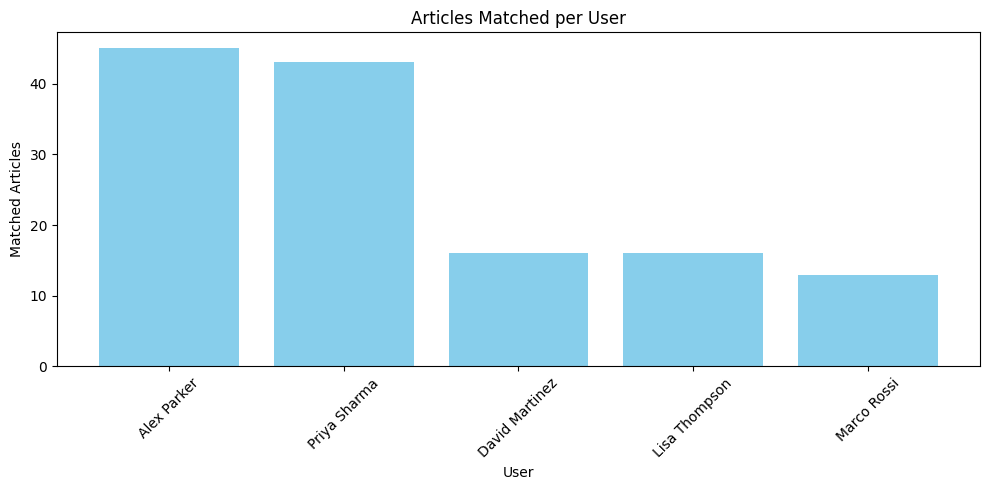

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(eval_df["User"], eval_df["Articles Matched"], color='skyblue')
plt.title("Articles Matched per User")
plt.xlabel("User")
plt.ylabel("Matched Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("assets/articles_matched_per_user.png", bbox_inches='tight')
plt.show()


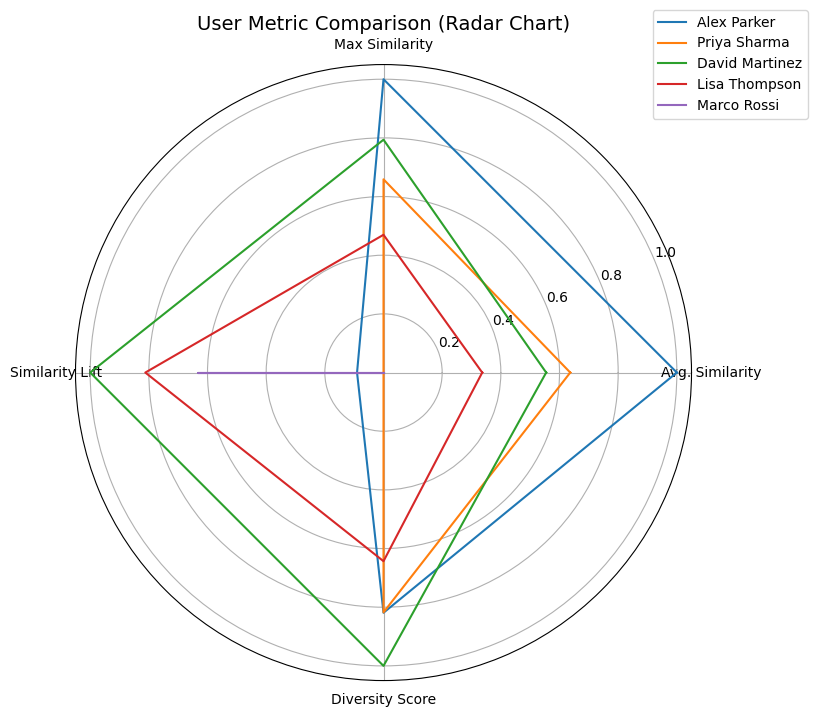

In [113]:
from math import pi

# Normalize selected columns
metrics = ['Avg. Similarity', 'Max Similarity', 'Similarity Lift', 'Diversity Score']
df_norm = eval_df.copy()
df_norm[metrics] = df_norm[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # close the loop

plt.figure(figsize=(8, 8))

for idx, row in df_norm.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # close the loop
    plt.polar(angles, values, label=row['User'])

plt.xticks(angles[:-1], labels)
plt.title("User Metric Comparison (Radar Chart)", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
os.makedirs("assets", exist_ok=True)
plt.savefig("assets/user_radar.png", bbox_inches='tight')
plt.show()

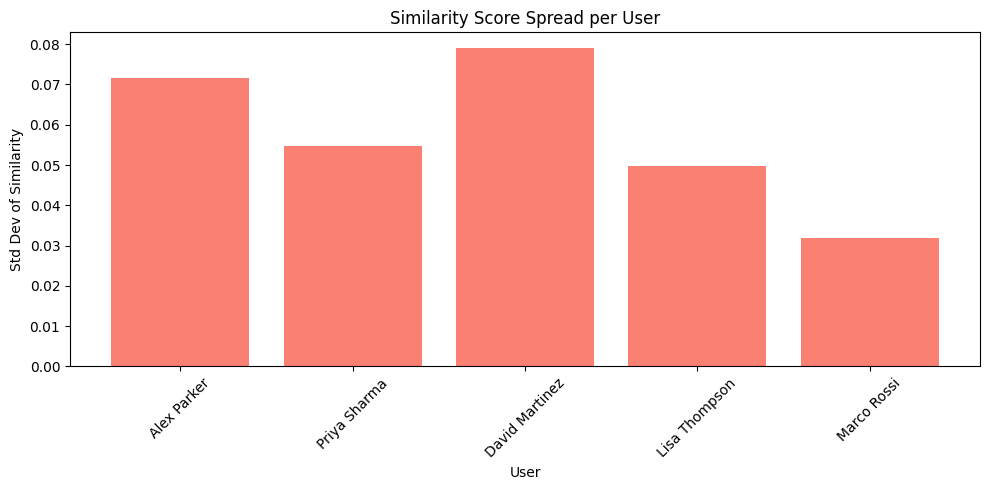

In [115]:
plt.figure(figsize=(10, 5))
plt.bar(eval_df["User"], eval_df["Std Dev of Similarity"], color='salmon')
plt.title("Similarity Score Spread per User")
plt.xlabel("User")
plt.ylabel("Std Dev of Similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("assets/similarity_std_dev_per_user.png", bbox_inches='tight')
plt.show()